In [1]:
import numpy as np
from scipy import sparse
from skimage.transform import resize
import ipywidgets as widgets
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

\begin{align*}
    \Sigma_1 &= J_{0,1} \Sigma_0 J^T_{0,1} \\
    \Sigma_2 &= J_{1,2} \Sigma_1 J^T_{1,2} \\
        &= J_{1,2} J_{0,1} \Sigma_0 J^T_{0,1} J^T_{1,2} \\
        &= J_{1,2} J_{0,1} \Sigma_0 (J_{1,2} J_{0,1})^T \\
        &= J_{0,2} \Sigma_0 J_{0,2}^T, & \text{with } J_{0,2} &= J_{1,2} J_{0,1}
\end{align*}

In [2]:
rsp = np.load('../../Data/simple_pCT/Phantoms/Head/RSP.npy')

In [3]:
scale = 1
phantom = np.pad(rsp[:,:,rsp.shape[2]//2], ((30*scale,30*scale), (100*scale, 100*scale)))

phantom = resize( phantom, (130, 130), anti_aliasing=True )

x = phantom.flatten()
RSP_shape = phantom.shape[:2]
print(RSP_shape)

(130, 130)


In [4]:
num_angle = 179
num_offset = 30
num_spotx = 190
chord_length = 'exact'

In [5]:
mlp = sparse.load_npz(f'../../Data/simple_pCT/MLP/MLP_angles{num_angle}_offset{num_offset}_spotx{num_spotx}_exact_{RSP_shape[0]}_{RSP_shape[1]}.npz')

In [6]:
numberOfSamples = 50

i1, i2, i3 = np.indices((num_spotx, numberOfSamples, num_angle))

rng = np.random.default_rng()
# mean of 15 and 99% are within 3 * std = 15
i2_random = rng.normal(15, 5, (num_spotx, numberOfSamples, num_angle)).astype(np.int64)
i2_random[ i2_random < 0 ] = 0
i2_random[ i2_random > num_offset - 1 ] = num_offset - 1

# i2 = np.random.randint(0, 30, size=(num_angles, num_offsets, num_spotxs))


idx = np.ravel_multi_index((i1, i2_random, i3), (num_spotx, num_offset, num_angle))
MLP_random = mlp[idx.flatten(), :]

b_w = MLP_random @ x
wepls = np.reshape(b_w, (num_spotx, numberOfSamples, num_angle))

In [7]:
obj = np.zeros(RSP_shape, dtype='bool')
for i in range(RSP_shape[0]):
    for j in range(RSP_shape[1]):
        # a circle is used as a valid volume
        vec = np.array([i, j])
        center = np.array(RSP_shape) // 2 
        
        obj[i,j] = True if (i - center[0])**2 / center[0]**2 + (j - center[1])**2 / center[1]**2 <= 1 else False

obj = obj.flatten()

# Using straight MLPs

In [11]:
i1, i2, i3 = np.indices((num_spotx, 1, num_angle))

reconstructions = np.empty((numberOfSamples,np.prod(RSP_shape)))
lamb = 0.5
idx = np.ravel_multi_index((i1, 15, i3), (num_spotx, num_offset, num_angle))
straight_mlp = mlp[idx.flatten(), :]

A_norm = sparse.linalg.norm(straight_mlp, axis=1)**2
valid = A_norm > 1e-9
A_norm = A_norm[valid]

S_array = np.array([straight_mlp[:,i].count_nonzero() for i in range(straight_mlp.shape[1])])
S_array[ S_array <= 0 ] = 1
S_array = 1 / S_array
for edx in tqdm(range(numberOfSamples)):

    x = np.random.random(np.prod(RSP_shape))

    A = straight_mlp[valid,:]
    b = wepls[:,edx,:].flatten()[valid]
    S_lamb = S_array * lamb
    latError = np.inf
    for iter in range(2000):
        Ax = A @ x

        residuals = b - Ax
        factor = residuals / A_norm
        x += S_lamb * (A.T @ factor)

        residualError = np.linalg.norm(residuals)

        x[~obj] = 0
    
    reconstructions[edx,:] = x

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
@widgets.interact(edx=(0,numberOfSamples-1,1))
def show(edx=0):
    plt.figure(figsize=(18,6))
    plt.imshow(reconstructions[edx].reshape(RSP_shape))
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='edx', max=49), Output()), _dom_classes=('widget-interact…

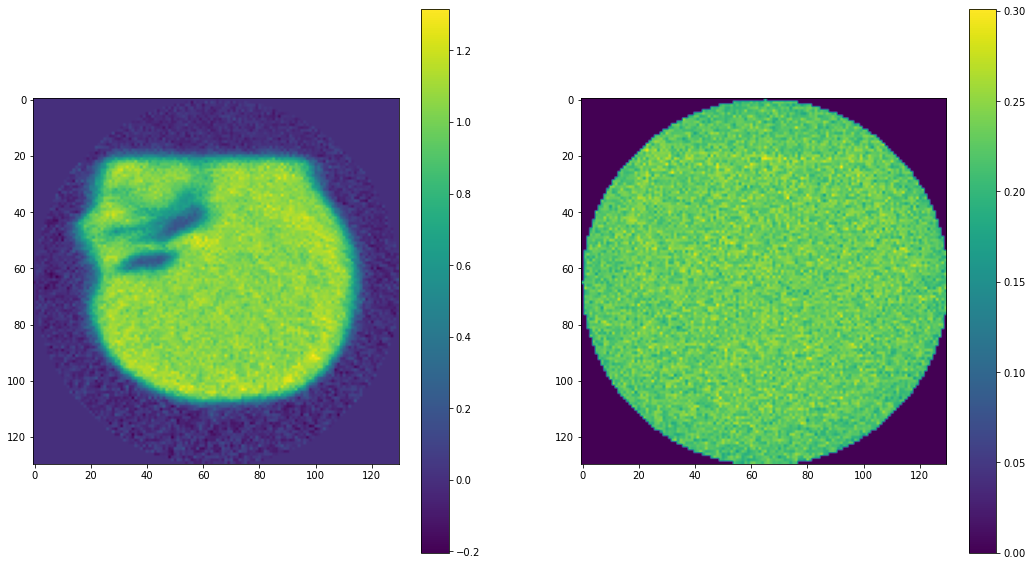

In [49]:
mean_reconstruction = np.mean(reconstructions, axis=0).reshape(RSP_shape)
std_reconstruction = np.std(reconstructions, axis=0).reshape(RSP_shape)

plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.imshow(mean_reconstruction)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(std_reconstruction)
plt.colorbar()

plt.show()